Реших проекта ми да е състезанието в kaggle за намиране на ядра на клетки в снимки: https://www.kaggle.com/c/data-science-bowl-2018

Оценяването използва IoU (Intersection over Union, която се смята по формулата (A∩B)/(A∪B), където A и B са множества от пиксели) метрика с различни прагове: 0.5, 0.55, 0.6, .., 0.95.

За праг "t" се смята TP(t)/(TP(t)+FP(t)+FN(t)) ако IoU за поне едно от ядрата е по-голямо от прага, се счита че ядрото е успешно намерено - TP. Ядрата нямат право да се застъпват. После се взима средното аритметично на резултатите за всеки праг.

Накрая се взима средното аритметично на резултатите от всяка снимка, за да се получи крайния резултат.

Освен това за да се спести памет от файла който се submit-ва, резултата се encode-ва с RLE (Run Length Encoding).

Ще използвам невронна мрежа за да реша проблема.
Тъй като ще обработвам снимки, конвулюционна невронна мрежа е най-подходяща.
Реших да прегледам дискусиите и kernel-ите за състезанието и установих, че повечето (от по-добрите) kernel-и използват U-Net невронна мрежа, което е конвулюционна невронна мрежа за "biomedical image segmentation" (няма да се мъча да го превеждам). Запознах се по подробно с мрежата от следния сайт:
https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

После разгледах по-подробно най-upvote-натия kernel:
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
Първоначално просто го пуснах и инсталирах python3 модулите които ми липсваха.
За около 10 минути получи следните резултати на training set-a:
loss: 0.0663 - mean_iou: 0.8250 - val_loss: 0.0684 - val_mean_iou: 0.8257
После прочетох дискусиите по kernel-а и реших да опитам да имплементирам съветите, които хората бяха дали за подобряване на kernel-а.

Kernel-а използва Keras.
Започвам като import–вам всичко което смятам, че ще ми трябва и задавам стойности няколко константи.
Тук променям стойностите на константите IMG_WIDTH и IMG_HEIGHT от 128х128 на 256х256, тъй като това е резолюцията на повечето данни в dataset-а и в дискусиите няколко човека казват, че са направили тази промяна за да подобрят резултатите си.

In [1]:
import os
import sys
import random
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label, opening, closing, disk

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'

seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


После си записвам имената (id-тата) на снимките от train и test.

In [2]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

## Зареждам снимките
Първо вкарвам всички снимки и съответните маски за всяко ядро. Променям размера на някои от снимките (не всички са 256х256), но запомням първоначалните им размери (само на test set-a) за да scale-на резултатите накрая и да получа верни run-length encoding-и накрая.

In [3]:
# Зареждам и resize-вам train снимките и маските
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Зареждане и resize-ване на train снимките и маските ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    # Сливам маските на всички ядра от дадена снимка в една маска
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Зареждам и resize-вам test снимките
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Зареждане и resize-ване на test снимките ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Зареждане и resize-ване на train снимките и маските ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:55<00:00,  3.81it/s]


Зареждане и resize-ване на test снимките ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 46.22it/s]


Done!


Проверяваме, че всичко е наред с маските на train set-а (че успешно сме ги комбинирали), като рисуваме произволна снимка и съответната и маска.

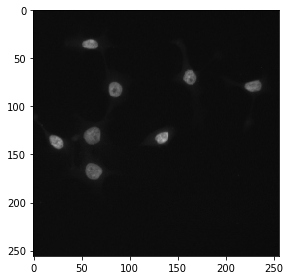

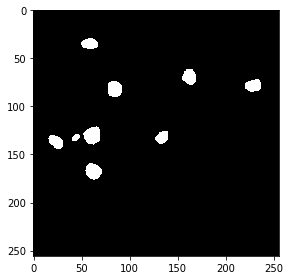

In [4]:
# Проверка дали train data-та изглежда вярно
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

Изглежда супер!

## Да си направим Keras метрика
По точно метриката по която ще оценяват решението ни. Tensorflow вече си има IoU метрика, но не поддържа средно аритметично от различни прагове. Затова го имплементираме сами (по-точно засега ще използваме имплементацията в kernel-а който намерих, която изглежда е грешна - по-точно не е като тази в условието но ще свърши работа). В случая проблема е че алгоритъма по който се изчислява истинския score е твърде сложен. Разглежда отделните ядра отделно, а ние искаме нещо по-просто, което да се смята бързо - затова слагаме всички ядра на една картинка и сравняваме картинките така. 

In [5]:
# Дефинираме IoU метрика
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

## Строим и тренираме невронната мрежа
Използваме U-Net модела, за който споменахме по-рано. По-подробно описан на:
[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) и използвам в [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) от друго kaggle състезание.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [6]:
# Строим U-Net модела
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 256, 256, 16) 4624        concatenate_4[0][0]              
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 256, 256, 16) 2320        dropout_9[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 1)  17          conv2d_18[0][0]                  
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________


Използваме elu вместо relu.
Добавяме dropout за регуляризация.
За метрика използваме нашата функция: mean_iou
Останалото е като в U-Net

Тренираме модела с validation split 0.1 тъй като имаме много малко data.
Пускаме 50 епохи и earlystopper, така че ако резултата спре да се подобрява да си спестим време за трениране. Правим и checkpoint-и на всяка епоха.
Със сегашните параметри тренирането отнема около 10-15 минути с размери на снимките 128х128 и около 30 минути за 256х256.
Update: намалям епохите на 5 защото това вече не е финалния модел и не ми трябва да е добър.

In [8]:
# Тренираме модела
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=5, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/5
592/603 [============================>.] - ETA: 5:08 - loss: 0.7005 - mean_iou: 0.0000e+ - ETA: 2:46 - loss: 0.6756 - mean_iou: 0.2201   - ETA: 1:58 - loss: 0.6619 - mean_iou: 0.29 - ETA: 1:34 - loss: 0.6307 - mean_iou: 0.32 - ETA: 1:19 - loss: 0.6048 - mean_iou: 0.34 - ETA: 1:08 - loss: 0.5759 - mean_iou: 0.35 - ETA: 1:01 - loss: 0.5566 - mean_iou: 0.36 - ETA: 55s - loss: 0.5373 - mean_iou: 0.3749 - ETA: 50s - loss: 0.6381 - mean_iou: 0.380 - ETA: 46s - loss: 0.6151 - mean_iou: 0.385 - ETA: 42s - loss: 0.6002 - mean_iou: 0.389 - ETA: 39s - loss: 0.5883 - mean_iou: 0.393 - ETA: 37s - loss: 0.5690 - mean_iou: 0.395 - ETA: 34s - loss: 0.5556 - mean_iou: 0.398 - ETA: 32s - loss: 0.5511 - mean_iou: 0.400 - ETA: 30s - loss: 0.5430 - mean_iou: 0.402 - ETA: 28s - loss: 0.5332 - mean_iou: 0.404 - ETA: 26s - loss: 0.5240 - mean_iou: 0.405 - ETA: 24s - loss: 0.5161 - mean_iou: 0.407 - ETA: 23s - loss: 0.5125 - mean_iou: 0.408 - ETA: 21s - lo

592/603 [============================>.] - ETA: 33s - loss: 0.0902 - mean_iou: 0.682 - ETA: 33s - loss: 0.1036 - mean_iou: 0.682 - ETA: 32s - loss: 0.0940 - mean_iou: 0.682 - ETA: 32s - loss: 0.0940 - mean_iou: 0.683 - ETA: 31s - loss: 0.0937 - mean_iou: 0.683 - ETA: 30s - loss: 0.0935 - mean_iou: 0.683 - ETA: 29s - loss: 0.0942 - mean_iou: 0.684 - ETA: 29s - loss: 0.0956 - mean_iou: 0.684 - ETA: 28s - loss: 0.0952 - mean_iou: 0.685 - ETA: 27s - loss: 0.0971 - mean_iou: 0.685 - ETA: 26s - loss: 0.0960 - mean_iou: 0.685 - ETA: 25s - loss: 0.0939 - mean_iou: 0.686 - ETA: 24s - loss: 0.0965 - mean_iou: 0.686 - ETA: 23s - loss: 0.1000 - mean_iou: 0.687 - ETA: 22s - loss: 0.0994 - mean_iou: 0.687 - ETA: 21s - loss: 0.1017 - mean_iou: 0.687 - ETA: 20s - loss: 0.1018 - mean_iou: 0.688 - ETA: 19s - loss: 0.1018 - mean_iou: 0.688 - ETA: 18s - loss: 0.1037 - mean_iou: 0.688 - ETA: 17s - loss: 0.1026 - mean_iou: 0.689 - ETA: 16s - loss: 0.1092 - mean_iou: 0.689 - ETA: 15s - loss: 0.1097 - mean_io

## Да направим prediction-ите
Ще направим prediction-и за test set-а validation set-а и train set-a (за да видим дали все пак дава добри резултати). Зареждаме най-добрия модел.

In [9]:
# Predict-ваме train, validation и test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Обръщаме prediction-ите от вероятности в нули и единици
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Обръщаме маските в първоначалните размери размери на снимките
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 1s 23ms/step


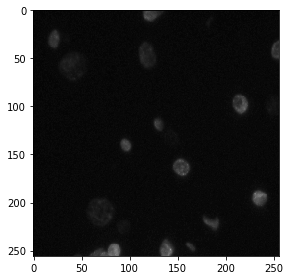

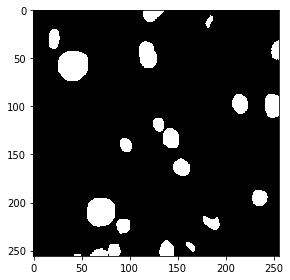

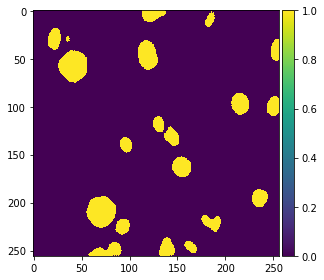

In [10]:
# Проверявам дали е направило каквото трябва за произволна train снимка
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

Изглежда сравнително добре.
Пробваме същото и с validation data.

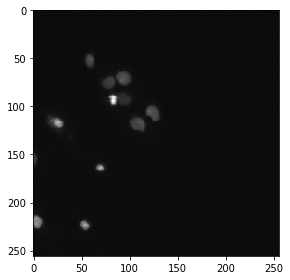

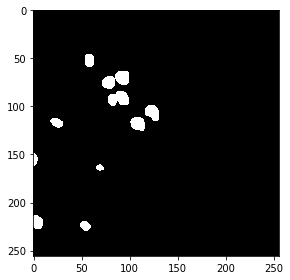

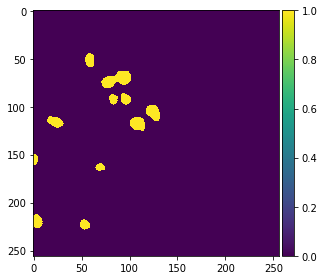

In [11]:
# Проверявам дали е направило каквото трябва за произволна validation снимка
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(Y_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

Отново се справя сравнително добре.

## Encode-ваме и submit-ваме резултата
Всъщност засега няма да го submit-ваме наистина. Първо ще го оптимизираме с някои идеи от дискусиите.
Използваме кратка имплементация на run-length encoding от интернет:

In [12]:
# Run-length encoding от тук: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x): # Получава матрица от bit-ове
    dots = np.where(x.T.flatten() == 1)[0] # Обръщаме матрицата в масив и получаваме списък от индекси на които има единица
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff) # Обръща вероятностите в нули и единици и после номерира свързаните компоненти
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i) # Encode-ваме всяка свързана компонента

Минаваме през имената (id-тата) на test снимките и генерираме run-length encoding за всяка маска намерена от skimage:

In [13]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [14]:
# Правим файла за submit-ване
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

Сред коментарите намираме съвета да сменим metric функцията (която и без друго е грешна) на dice coefficient, което е по-близо до истинското оценяване:
(2|A∩B|+1)/(|A|+|B|+1), където 1 е константа за "заглаждане"
Тук обаче го прилагаме за комбинираната маска на всички клетки. Съответно няма и threshhold-ове.
Имплементираме функцията, като ще пробваме да я използваме и за loss функция.

In [15]:
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

Още нещо. Тъй като различните снимки имат различен контраст, ще е добре да ги нормализираме. В случая това значи за всеки канал (red, green, blue) на дадена снимка да използваме числата от 0 до 255 (а не например от 0 до 100 на по тъмни снимки или от 100 до 255 на по светли). За целта използваме следната функция с която preprocess-ваме всички снимки:

In [16]:
def scale_img_canals(an_img):
    for i in range(IMG_CHANNELS):
        canal = an_img[:,:,i]
        canal = canal - canal.min()
        canalmax = canal.max()
        if canalmax > 0:
            factor = 255/canalmax
            canal = (canal * factor).astype(int)
        an_img[:,:,i] = canal

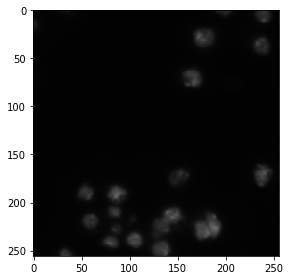

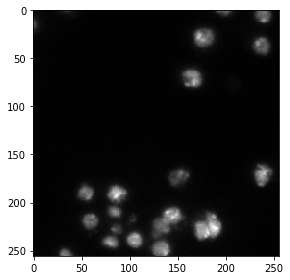

In [17]:
# Тестваме дали работи правилно с:
imshow(X_train[0])
plt.show()
scale_img_canals(X_train[0])
imshow(X_train[0])
plt.show()


Изглежда работи. Ще го приложим върху данните щом ги прочетем.

Имайки предвид алгоритъма за оценяване, забелязваме че ако има 1 "самотен" бял пиксел някъде в резултата, той ще се счита за отделно ядро и независимо дали там има ядро или не той няма да е достатъчен за да се брои за намерено даденото ядро. Поради тази причина такива "самотни" пиксели само намаляват резултата ни. И то забележимо. Ще подобрим резултата си като приложим прости филтри на prediction-а които отстряняват такъв шум преди run-length encoding-а.
Ето пример за такъв филтър:

In [18]:
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))

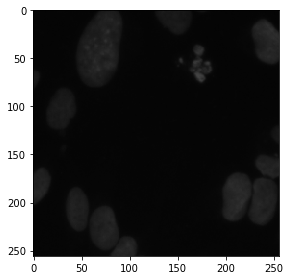

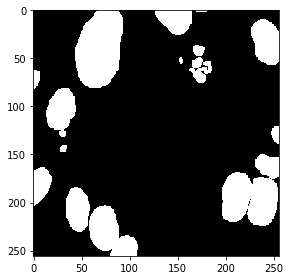

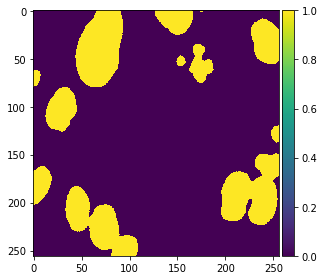

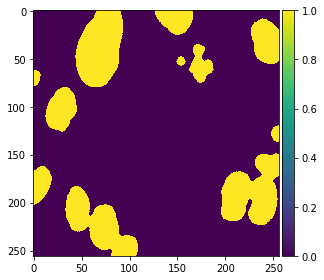

In [19]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(Y_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
imshow(clean_img(np.squeeze(preds_val_t[ix])))
plt.show()

## Сега да направим всичко отначало с нанесените промени:

In [20]:
# Зареждам и resize-вам train снимките и маските
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Зареждане и resize-ване на train снимките и маските ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    scale_img_canals(img)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    # Сливам маските на всички ядра от дадена снимка в една маска
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Зареждам и resize-вам test снимките
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Зареждане и resize-ване на test снимките ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    scale_img_canals(img)
    X_test[n] = img

print('Done!')

Зареждане и resize-ване на train снимките и маските ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:53<00:00,  3.87it/s]


Зареждане и resize-ване на test снимките ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 46.03it/s]


Done!


In [21]:
model.compile(optimizer = 'adam', 
                   loss = 'binary_crossentropy', 
                   metrics = [dice_coef])

In [22]:
# Тренираме модела
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-2.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/100
592/603 [============================>.] - ETA: 1:53 - loss: 0.1223 - dice_coef: 0.814 - ETA: 1:11 - loss: 0.1526 - dice_coef: 0.767 - ETA: 56s - loss: 0.1268 - dice_coef: 0.793 - ETA: 48s - loss: 0.1073 - dice_coef: 0.79 - ETA: 43s - loss: 0.0987 - dice_coef: 0.78 - ETA: 39s - loss: 0.1035 - dice_coef: 0.77 - ETA: 37s - loss: 0.1045 - dice_coef: 0.77 - ETA: 34s - loss: 0.1051 - dice_coef: 0.77 - ETA: 32s - loss: 0.0989 - dice_coef: 0.78 - ETA: 30s - loss: 0.0998 - dice_coef: 0.79 - ETA: 29s - loss: 0.1007 - dice_coef: 0.79 - ETA: 27s - loss: 0.1000 - dice_coef: 0.79 - ETA: 26s - loss: 0.1002 - dice_coef: 0.79 - ETA: 24s - loss: 0.0987 - dice_coef: 0.80 - ETA: 23s - loss: 0.0988 - dice_coef: 0.80 - ETA: 22s - loss: 0.1021 - dice_coef: 0.80 - ETA: 21s - loss: 0.1017 - dice_coef: 0.80 - ETA: 20s - loss: 0.1008 - dice_coef: 0.80 - ETA: 18s - loss: 0.1005 - dice_coef: 0.80 - ETA: 17s - loss: 0.1002 - dice_coef: 0.80 - ETA: 16s - loss

592/603 [============================>.] - ETA: 39s - loss: 0.0662 - dice_coef: 0.86 - ETA: 38s - loss: 0.0685 - dice_coef: 0.84 - ETA: 36s - loss: 0.0723 - dice_coef: 0.85 - ETA: 35s - loss: 0.0684 - dice_coef: 0.85 - ETA: 34s - loss: 0.0722 - dice_coef: 0.84 - ETA: 33s - loss: 0.0788 - dice_coef: 0.84 - ETA: 32s - loss: 0.0792 - dice_coef: 0.83 - ETA: 32s - loss: 0.0853 - dice_coef: 0.84 - ETA: 31s - loss: 0.0832 - dice_coef: 0.84 - ETA: 30s - loss: 0.0822 - dice_coef: 0.84 - ETA: 28s - loss: 0.0802 - dice_coef: 0.84 - ETA: 27s - loss: 0.0774 - dice_coef: 0.85 - ETA: 26s - loss: 0.0789 - dice_coef: 0.85 - ETA: 25s - loss: 0.0782 - dice_coef: 0.85 - ETA: 24s - loss: 0.0784 - dice_coef: 0.85 - ETA: 23s - loss: 0.0790 - dice_coef: 0.85 - ETA: 22s - loss: 0.0791 - dice_coef: 0.85 - ETA: 21s - loss: 0.0783 - dice_coef: 0.85 - ETA: 20s - loss: 0.0778 - dice_coef: 0.85 - ETA: 19s - loss: 0.0782 - dice_coef: 0.85 - ETA: 18s - loss: 0.0799 - dice_coef: 0.85 - ETA: 17s - loss: 0.0804 - dice_co

592/603 [============================>.] - ETA: 40s - loss: 0.0819 - dice_coef: 0.84 - ETA: 39s - loss: 0.0793 - dice_coef: 0.85 - ETA: 38s - loss: 0.0712 - dice_coef: 0.86 - ETA: 37s - loss: 0.0718 - dice_coef: 0.86 - ETA: 36s - loss: 0.0692 - dice_coef: 0.86 - ETA: 35s - loss: 0.0675 - dice_coef: 0.86 - ETA: 34s - loss: 0.0722 - dice_coef: 0.86 - ETA: 32s - loss: 0.0779 - dice_coef: 0.86 - ETA: 31s - loss: 0.0777 - dice_coef: 0.86 - ETA: 30s - loss: 0.0781 - dice_coef: 0.85 - ETA: 29s - loss: 0.0769 - dice_coef: 0.85 - ETA: 28s - loss: 0.0765 - dice_coef: 0.85 - ETA: 27s - loss: 0.0817 - dice_coef: 0.85 - ETA: 26s - loss: 0.0810 - dice_coef: 0.85 - ETA: 25s - loss: 0.0815 - dice_coef: 0.85 - ETA: 24s - loss: 0.0812 - dice_coef: 0.85 - ETA: 22s - loss: 0.0820 - dice_coef: 0.84 - ETA: 21s - loss: 0.0806 - dice_coef: 0.84 - ETA: 20s - loss: 0.0806 - dice_coef: 0.84 - ETA: 19s - loss: 0.0801 - dice_coef: 0.84 - ETA: 18s - loss: 0.0794 - dice_coef: 0.84 - ETA: 17s - loss: 0.0782 - dice_co

592/603 [============================>.] - ETA: 40s - loss: 0.0491 - dice_coef: 0.88 - ETA: 39s - loss: 0.0581 - dice_coef: 0.87 - ETA: 37s - loss: 0.0724 - dice_coef: 0.86 - ETA: 36s - loss: 0.0738 - dice_coef: 0.86 - ETA: 35s - loss: 0.0822 - dice_coef: 0.85 - ETA: 34s - loss: 0.0786 - dice_coef: 0.85 - ETA: 33s - loss: 0.0827 - dice_coef: 0.85 - ETA: 32s - loss: 0.0811 - dice_coef: 0.85 - ETA: 31s - loss: 0.0828 - dice_coef: 0.85 - ETA: 30s - loss: 0.0828 - dice_coef: 0.85 - ETA: 29s - loss: 0.0807 - dice_coef: 0.85 - ETA: 28s - loss: 0.0820 - dice_coef: 0.85 - ETA: 26s - loss: 0.0801 - dice_coef: 0.85 - ETA: 25s - loss: 0.0800 - dice_coef: 0.85 - ETA: 24s - loss: 0.0787 - dice_coef: 0.85 - ETA: 23s - loss: 0.0785 - dice_coef: 0.85 - ETA: 22s - loss: 0.0776 - dice_coef: 0.86 - ETA: 21s - loss: 0.0769 - dice_coef: 0.86 - ETA: 20s - loss: 0.0757 - dice_coef: 0.86 - ETA: 19s - loss: 0.0755 - dice_coef: 0.85 - ETA: 18s - loss: 0.0755 - dice_coef: 0.85 - ETA: 17s - loss: 0.0765 - dice_co

592/603 [============================>.] - ETA: 41s - loss: 0.0702 - dice_coef: 0.85 - ETA: 40s - loss: 0.0787 - dice_coef: 0.85 - ETA: 39s - loss: 0.0770 - dice_coef: 0.85 - ETA: 38s - loss: 0.0718 - dice_coef: 0.86 - ETA: 36s - loss: 0.0698 - dice_coef: 0.86 - ETA: 35s - loss: 0.0738 - dice_coef: 0.86 - ETA: 34s - loss: 0.0778 - dice_coef: 0.85 - ETA: 33s - loss: 0.0775 - dice_coef: 0.86 - ETA: 32s - loss: 0.0737 - dice_coef: 0.86 - ETA: 31s - loss: 0.0736 - dice_coef: 0.86 - ETA: 30s - loss: 0.0730 - dice_coef: 0.86 - ETA: 29s - loss: 0.0723 - dice_coef: 0.86 - ETA: 27s - loss: 0.0722 - dice_coef: 0.86 - ETA: 26s - loss: 0.0722 - dice_coef: 0.86 - ETA: 25s - loss: 0.0700 - dice_coef: 0.86 - ETA: 24s - loss: 0.0688 - dice_coef: 0.86 - ETA: 23s - loss: 0.0690 - dice_coef: 0.86 - ETA: 22s - loss: 0.0678 - dice_coef: 0.86 - ETA: 21s - loss: 0.0666 - dice_coef: 0.87 - ETA: 20s - loss: 0.0653 - dice_coef: 0.87 - ETA: 18s - loss: 0.0667 - dice_coef: 0.87 - ETA: 17s - loss: 0.0673 - dice_co

592/603 [============================>.] - ETA: 38s - loss: 0.1252 - dice_coef: 0.79 - ETA: 37s - loss: 0.0933 - dice_coef: 0.83 - ETA: 36s - loss: 0.0983 - dice_coef: 0.82 - ETA: 35s - loss: 0.0884 - dice_coef: 0.83 - ETA: 34s - loss: 0.0849 - dice_coef: 0.83 - ETA: 33s - loss: 0.0823 - dice_coef: 0.84 - ETA: 32s - loss: 0.0769 - dice_coef: 0.85 - ETA: 31s - loss: 0.0761 - dice_coef: 0.85 - ETA: 30s - loss: 0.0790 - dice_coef: 0.85 - ETA: 29s - loss: 0.0806 - dice_coef: 0.85 - ETA: 28s - loss: 0.0789 - dice_coef: 0.85 - ETA: 27s - loss: 0.0788 - dice_coef: 0.85 - ETA: 26s - loss: 0.0778 - dice_coef: 0.85 - ETA: 25s - loss: 0.0784 - dice_coef: 0.85 - ETA: 24s - loss: 0.0783 - dice_coef: 0.85 - ETA: 23s - loss: 0.0782 - dice_coef: 0.85 - ETA: 21s - loss: 0.0761 - dice_coef: 0.85 - ETA: 20s - loss: 0.0747 - dice_coef: 0.85 - ETA: 19s - loss: 0.0738 - dice_coef: 0.85 - ETA: 18s - loss: 0.0725 - dice_coef: 0.85 - ETA: 17s - loss: 0.0717 - dice_coef: 0.85 - ETA: 16s - loss: 0.0727 - dice_co

592/603 [============================>.] - ETA: 40s - loss: 0.1136 - dice_coef: 0.85 - ETA: 39s - loss: 0.0892 - dice_coef: 0.87 - ETA: 38s - loss: 0.0790 - dice_coef: 0.88 - ETA: 37s - loss: 0.0697 - dice_coef: 0.88 - ETA: 36s - loss: 0.0646 - dice_coef: 0.88 - ETA: 35s - loss: 0.0658 - dice_coef: 0.88 - ETA: 34s - loss: 0.0649 - dice_coef: 0.88 - ETA: 33s - loss: 0.0650 - dice_coef: 0.87 - ETA: 32s - loss: 0.0628 - dice_coef: 0.87 - ETA: 30s - loss: 0.0645 - dice_coef: 0.87 - ETA: 29s - loss: 0.0640 - dice_coef: 0.87 - ETA: 28s - loss: 0.0642 - dice_coef: 0.87 - ETA: 27s - loss: 0.0623 - dice_coef: 0.87 - ETA: 26s - loss: 0.0633 - dice_coef: 0.87 - ETA: 25s - loss: 0.0633 - dice_coef: 0.87 - ETA: 24s - loss: 0.0638 - dice_coef: 0.87 - ETA: 23s - loss: 0.0637 - dice_coef: 0.87 - ETA: 21s - loss: 0.0640 - dice_coef: 0.87 - ETA: 20s - loss: 0.0642 - dice_coef: 0.87 - ETA: 19s - loss: 0.0660 - dice_coef: 0.87 - ETA: 18s - loss: 0.0657 - dice_coef: 0.87 - ETA: 17s - loss: 0.0649 - dice_co

592/603 [============================>.] - ETA: 41s - loss: 0.0610 - dice_coef: 0.84 - ETA: 40s - loss: 0.0735 - dice_coef: 0.85 - ETA: 39s - loss: 0.0734 - dice_coef: 0.85 - ETA: 38s - loss: 0.0726 - dice_coef: 0.86 - ETA: 37s - loss: 0.0722 - dice_coef: 0.86 - ETA: 36s - loss: 0.0730 - dice_coef: 0.86 - ETA: 35s - loss: 0.0774 - dice_coef: 0.86 - ETA: 33s - loss: 0.0748 - dice_coef: 0.87 - ETA: 32s - loss: 0.0759 - dice_coef: 0.86 - ETA: 31s - loss: 0.0768 - dice_coef: 0.86 - ETA: 30s - loss: 0.0732 - dice_coef: 0.86 - ETA: 29s - loss: 0.0720 - dice_coef: 0.87 - ETA: 28s - loss: 0.0707 - dice_coef: 0.86 - ETA: 27s - loss: 0.0688 - dice_coef: 0.87 - ETA: 26s - loss: 0.0680 - dice_coef: 0.87 - ETA: 24s - loss: 0.0679 - dice_coef: 0.87 - ETA: 23s - loss: 0.0673 - dice_coef: 0.87 - ETA: 22s - loss: 0.0660 - dice_coef: 0.87 - ETA: 21s - loss: 0.0652 - dice_coef: 0.87 - ETA: 20s - loss: 0.0658 - dice_coef: 0.87 - ETA: 19s - loss: 0.0641 - dice_coef: 0.87 - ETA: 18s - loss: 0.0639 - dice_co

592/603 [============================>.] - ETA: 39s - loss: 0.0634 - dice_coef: 0.88 - ETA: 38s - loss: 0.0669 - dice_coef: 0.87 - ETA: 37s - loss: 0.0660 - dice_coef: 0.87 - ETA: 36s - loss: 0.0607 - dice_coef: 0.88 - ETA: 35s - loss: 0.0581 - dice_coef: 0.88 - ETA: 34s - loss: 0.0571 - dice_coef: 0.88 - ETA: 33s - loss: 0.0583 - dice_coef: 0.88 - ETA: 32s - loss: 0.0576 - dice_coef: 0.88 - ETA: 31s - loss: 0.0619 - dice_coef: 0.88 - ETA: 29s - loss: 0.0597 - dice_coef: 0.88 - ETA: 28s - loss: 0.0595 - dice_coef: 0.88 - ETA: 27s - loss: 0.0631 - dice_coef: 0.88 - ETA: 26s - loss: 0.0618 - dice_coef: 0.88 - ETA: 25s - loss: 0.0619 - dice_coef: 0.88 - ETA: 24s - loss: 0.0604 - dice_coef: 0.88 - ETA: 23s - loss: 0.0594 - dice_coef: 0.88 - ETA: 22s - loss: 0.0587 - dice_coef: 0.88 - ETA: 21s - loss: 0.0587 - dice_coef: 0.88 - ETA: 20s - loss: 0.0586 - dice_coef: 0.88 - ETA: 19s - loss: 0.0605 - dice_coef: 0.88 - ETA: 18s - loss: 0.0606 - dice_coef: 0.88 - ETA: 17s - loss: 0.0609 - dice_co

592/603 [============================>.] - ETA: 40s - loss: 0.0727 - dice_coef: 0.86 - ETA: 39s - loss: 0.0640 - dice_coef: 0.87 - ETA: 38s - loss: 0.0648 - dice_coef: 0.87 - ETA: 37s - loss: 0.0604 - dice_coef: 0.87 - ETA: 36s - loss: 0.0549 - dice_coef: 0.88 - ETA: 35s - loss: 0.0621 - dice_coef: 0.87 - ETA: 34s - loss: 0.0598 - dice_coef: 0.88 - ETA: 33s - loss: 0.0610 - dice_coef: 0.88 - ETA: 32s - loss: 0.0599 - dice_coef: 0.88 - ETA: 31s - loss: 0.0589 - dice_coef: 0.88 - ETA: 29s - loss: 0.0581 - dice_coef: 0.88 - ETA: 28s - loss: 0.0585 - dice_coef: 0.88 - ETA: 27s - loss: 0.0586 - dice_coef: 0.88 - ETA: 26s - loss: 0.0579 - dice_coef: 0.88 - ETA: 25s - loss: 0.0585 - dice_coef: 0.88 - ETA: 24s - loss: 0.0589 - dice_coef: 0.88 - ETA: 23s - loss: 0.0583 - dice_coef: 0.88 - ETA: 22s - loss: 0.0575 - dice_coef: 0.88 - ETA: 20s - loss: 0.0587 - dice_coef: 0.88 - ETA: 19s - loss: 0.0591 - dice_coef: 0.88 - ETA: 18s - loss: 0.0584 - dice_coef: 0.88 - ETA: 17s - loss: 0.0598 - dice_co

592/603 [============================>.] - ETA: 42s - loss: 0.0561 - dice_coef: 0.87 - ETA: 41s - loss: 0.0502 - dice_coef: 0.88 - ETA: 40s - loss: 0.0526 - dice_coef: 0.88 - ETA: 38s - loss: 0.0506 - dice_coef: 0.88 - ETA: 37s - loss: 0.0516 - dice_coef: 0.89 - ETA: 36s - loss: 0.0498 - dice_coef: 0.89 - ETA: 35s - loss: 0.0525 - dice_coef: 0.89 - ETA: 34s - loss: 0.0546 - dice_coef: 0.89 - ETA: 33s - loss: 0.0584 - dice_coef: 0.88 - ETA: 32s - loss: 0.0560 - dice_coef: 0.88 - ETA: 30s - loss: 0.0557 - dice_coef: 0.89 - ETA: 29s - loss: 0.0561 - dice_coef: 0.89 - ETA: 28s - loss: 0.0575 - dice_coef: 0.89 - ETA: 27s - loss: 0.0572 - dice_coef: 0.89 - ETA: 26s - loss: 0.0563 - dice_coef: 0.88 - ETA: 25s - loss: 0.0560 - dice_coef: 0.88 - ETA: 24s - loss: 0.0571 - dice_coef: 0.88 - ETA: 22s - loss: 0.0563 - dice_coef: 0.88 - ETA: 21s - loss: 0.0563 - dice_coef: 0.88 - ETA: 20s - loss: 0.0560 - dice_coef: 0.88 - ETA: 19s - loss: 0.0569 - dice_coef: 0.88 - ETA: 18s - loss: 0.0570 - dice_co

592/603 [============================>.] - ETA: 42s - loss: 0.0510 - dice_coef: 0.89 - ETA: 41s - loss: 0.0540 - dice_coef: 0.89 - ETA: 40s - loss: 0.0578 - dice_coef: 0.88 - ETA: 39s - loss: 0.0521 - dice_coef: 0.89 - ETA: 38s - loss: 0.0548 - dice_coef: 0.88 - ETA: 37s - loss: 0.0583 - dice_coef: 0.88 - ETA: 35s - loss: 0.0565 - dice_coef: 0.89 - ETA: 34s - loss: 0.0547 - dice_coef: 0.89 - ETA: 33s - loss: 0.0560 - dice_coef: 0.89 - ETA: 32s - loss: 0.0568 - dice_coef: 0.89 - ETA: 31s - loss: 0.0574 - dice_coef: 0.89 - ETA: 30s - loss: 0.0565 - dice_coef: 0.89 - ETA: 28s - loss: 0.0570 - dice_coef: 0.89 - ETA: 27s - loss: 0.0566 - dice_coef: 0.89 - ETA: 26s - loss: 0.0560 - dice_coef: 0.89 - ETA: 25s - loss: 0.0556 - dice_coef: 0.89 - ETA: 24s - loss: 0.0545 - dice_coef: 0.89 - ETA: 23s - loss: 0.0546 - dice_coef: 0.89 - ETA: 21s - loss: 0.0541 - dice_coef: 0.89 - ETA: 20s - loss: 0.0558 - dice_coef: 0.89 - ETA: 19s - loss: 0.0550 - dice_coef: 0.89 - ETA: 18s - loss: 0.0544 - dice_co

592/603 [============================>.] - ETA: 42s - loss: 0.0801 - dice_coef: 0.87 - ETA: 41s - loss: 0.0654 - dice_coef: 0.89 - ETA: 40s - loss: 0.0584 - dice_coef: 0.89 - ETA: 39s - loss: 0.0551 - dice_coef: 0.89 - ETA: 38s - loss: 0.0524 - dice_coef: 0.89 - ETA: 37s - loss: 0.0501 - dice_coef: 0.90 - ETA: 36s - loss: 0.0493 - dice_coef: 0.90 - ETA: 34s - loss: 0.0490 - dice_coef: 0.90 - ETA: 33s - loss: 0.0478 - dice_coef: 0.90 - ETA: 32s - loss: 0.0491 - dice_coef: 0.90 - ETA: 31s - loss: 0.0480 - dice_coef: 0.90 - ETA: 30s - loss: 0.0483 - dice_coef: 0.90 - ETA: 29s - loss: 0.0482 - dice_coef: 0.90 - ETA: 27s - loss: 0.0493 - dice_coef: 0.90 - ETA: 26s - loss: 0.0505 - dice_coef: 0.90 - ETA: 25s - loss: 0.0513 - dice_coef: 0.90 - ETA: 24s - loss: 0.0527 - dice_coef: 0.89 - ETA: 23s - loss: 0.0528 - dice_coef: 0.90 - ETA: 22s - loss: 0.0528 - dice_coef: 0.89 - ETA: 20s - loss: 0.0524 - dice_coef: 0.89 - ETA: 19s - loss: 0.0527 - dice_coef: 0.90 - ETA: 18s - loss: 0.0521 - dice_co

592/603 [============================>.] - ETA: 42s - loss: 0.0543 - dice_coef: 0.89 - ETA: 41s - loss: 0.0445 - dice_coef: 0.89 - ETA: 40s - loss: 0.0411 - dice_coef: 0.90 - ETA: 39s - loss: 0.0462 - dice_coef: 0.90 - ETA: 38s - loss: 0.0461 - dice_coef: 0.90 - ETA: 37s - loss: 0.0445 - dice_coef: 0.90 - ETA: 36s - loss: 0.0449 - dice_coef: 0.90 - ETA: 34s - loss: 0.0448 - dice_coef: 0.90 - ETA: 33s - loss: 0.0444 - dice_coef: 0.90 - ETA: 32s - loss: 0.0436 - dice_coef: 0.90 - ETA: 31s - loss: 0.0443 - dice_coef: 0.90 - ETA: 30s - loss: 0.0439 - dice_coef: 0.90 - ETA: 29s - loss: 0.0442 - dice_coef: 0.90 - ETA: 27s - loss: 0.0460 - dice_coef: 0.90 - ETA: 26s - loss: 0.0458 - dice_coef: 0.90 - ETA: 25s - loss: 0.0461 - dice_coef: 0.90 - ETA: 24s - loss: 0.0463 - dice_coef: 0.90 - ETA: 23s - loss: 0.0471 - dice_coef: 0.90 - ETA: 21s - loss: 0.0465 - dice_coef: 0.90 - ETA: 20s - loss: 0.0470 - dice_coef: 0.90 - ETA: 19s - loss: 0.0474 - dice_coef: 0.90 - ETA: 18s - loss: 0.0476 - dice_co

592/603 [============================>.] - ETA: 43s - loss: 0.0422 - dice_coef: 0.92 - ETA: 41s - loss: 0.0481 - dice_coef: 0.92 - ETA: 40s - loss: 0.0457 - dice_coef: 0.92 - ETA: 39s - loss: 0.0451 - dice_coef: 0.92 - ETA: 38s - loss: 0.0454 - dice_coef: 0.92 - ETA: 37s - loss: 0.0449 - dice_coef: 0.92 - ETA: 35s - loss: 0.0482 - dice_coef: 0.91 - ETA: 34s - loss: 0.0485 - dice_coef: 0.91 - ETA: 33s - loss: 0.0476 - dice_coef: 0.91 - ETA: 32s - loss: 0.0479 - dice_coef: 0.91 - ETA: 31s - loss: 0.0481 - dice_coef: 0.91 - ETA: 30s - loss: 0.0476 - dice_coef: 0.91 - ETA: 28s - loss: 0.0479 - dice_coef: 0.91 - ETA: 27s - loss: 0.0479 - dice_coef: 0.91 - ETA: 26s - loss: 0.0481 - dice_coef: 0.91 - ETA: 25s - loss: 0.0480 - dice_coef: 0.91 - ETA: 24s - loss: 0.0479 - dice_coef: 0.91 - ETA: 23s - loss: 0.0480 - dice_coef: 0.91 - ETA: 21s - loss: 0.0475 - dice_coef: 0.91 - ETA: 20s - loss: 0.0481 - dice_coef: 0.91 - ETA: 19s - loss: 0.0475 - dice_coef: 0.91 - ETA: 18s - loss: 0.0472 - dice_co

592/603 [============================>.] - ETA: 42s - loss: 0.0553 - dice_coef: 0.88 - ETA: 41s - loss: 0.0474 - dice_coef: 0.89 - ETA: 40s - loss: 0.0462 - dice_coef: 0.90 - ETA: 39s - loss: 0.0453 - dice_coef: 0.90 - ETA: 38s - loss: 0.0460 - dice_coef: 0.90 - ETA: 37s - loss: 0.0497 - dice_coef: 0.90 - ETA: 36s - loss: 0.0493 - dice_coef: 0.90 - ETA: 35s - loss: 0.0477 - dice_coef: 0.90 - ETA: 33s - loss: 0.0471 - dice_coef: 0.90 - ETA: 32s - loss: 0.0471 - dice_coef: 0.90 - ETA: 31s - loss: 0.0459 - dice_coef: 0.90 - ETA: 30s - loss: 0.0465 - dice_coef: 0.90 - ETA: 29s - loss: 0.0456 - dice_coef: 0.90 - ETA: 28s - loss: 0.0456 - dice_coef: 0.90 - ETA: 26s - loss: 0.0457 - dice_coef: 0.90 - ETA: 25s - loss: 0.0453 - dice_coef: 0.91 - ETA: 24s - loss: 0.0448 - dice_coef: 0.91 - ETA: 23s - loss: 0.0446 - dice_coef: 0.91 - ETA: 22s - loss: 0.0452 - dice_coef: 0.91 - ETA: 20s - loss: 0.0452 - dice_coef: 0.91 - ETA: 19s - loss: 0.0460 - dice_coef: 0.90 - ETA: 18s - loss: 0.0456 - dice_co

592/603 [============================>.] - ETA: 42s - loss: 0.0421 - dice_coef: 0.91 - ETA: 42s - loss: 0.0463 - dice_coef: 0.91 - ETA: 40s - loss: 0.0468 - dice_coef: 0.90 - ETA: 39s - loss: 0.0490 - dice_coef: 0.90 - ETA: 38s - loss: 0.0496 - dice_coef: 0.90 - ETA: 37s - loss: 0.0478 - dice_coef: 0.90 - ETA: 36s - loss: 0.0459 - dice_coef: 0.91 - ETA: 35s - loss: 0.0432 - dice_coef: 0.91 - ETA: 33s - loss: 0.0438 - dice_coef: 0.91 - ETA: 32s - loss: 0.0442 - dice_coef: 0.91 - ETA: 31s - loss: 0.0440 - dice_coef: 0.91 - ETA: 30s - loss: 0.0437 - dice_coef: 0.91 - ETA: 29s - loss: 0.0447 - dice_coef: 0.91 - ETA: 28s - loss: 0.0444 - dice_coef: 0.91 - ETA: 26s - loss: 0.0446 - dice_coef: 0.91 - ETA: 25s - loss: 0.0441 - dice_coef: 0.91 - ETA: 24s - loss: 0.0433 - dice_coef: 0.91 - ETA: 23s - loss: 0.0436 - dice_coef: 0.91 - ETA: 22s - loss: 0.0432 - dice_coef: 0.91 - ETA: 20s - loss: 0.0432 - dice_coef: 0.91 - ETA: 19s - loss: 0.0430 - dice_coef: 0.91 - ETA: 18s - loss: 0.0426 - dice_co

592/603 [============================>.] - ETA: 42s - loss: 0.0395 - dice_coef: 0.90 - ETA: 41s - loss: 0.0341 - dice_coef: 0.92 - ETA: 40s - loss: 0.0382 - dice_coef: 0.91 - ETA: 39s - loss: 0.0370 - dice_coef: 0.92 - ETA: 38s - loss: 0.0346 - dice_coef: 0.92 - ETA: 37s - loss: 0.0346 - dice_coef: 0.92 - ETA: 36s - loss: 0.0357 - dice_coef: 0.92 - ETA: 35s - loss: 0.0367 - dice_coef: 0.92 - ETA: 34s - loss: 0.0397 - dice_coef: 0.92 - ETA: 32s - loss: 0.0394 - dice_coef: 0.92 - ETA: 31s - loss: 0.0402 - dice_coef: 0.92 - ETA: 30s - loss: 0.0410 - dice_coef: 0.92 - ETA: 29s - loss: 0.0406 - dice_coef: 0.92 - ETA: 28s - loss: 0.0400 - dice_coef: 0.92 - ETA: 26s - loss: 0.0404 - dice_coef: 0.92 - ETA: 25s - loss: 0.0402 - dice_coef: 0.92 - ETA: 24s - loss: 0.0399 - dice_coef: 0.92 - ETA: 23s - loss: 0.0399 - dice_coef: 0.92 - ETA: 22s - loss: 0.0394 - dice_coef: 0.92 - ETA: 21s - loss: 0.0400 - dice_coef: 0.92 - ETA: 19s - loss: 0.0393 - dice_coef: 0.92 - ETA: 18s - loss: 0.0390 - dice_co

592/603 [============================>.] - ETA: 40s - loss: 0.0287 - dice_coef: 0.92 - ETA: 39s - loss: 0.0255 - dice_coef: 0.92 - ETA: 38s - loss: 0.0292 - dice_coef: 0.92 - ETA: 37s - loss: 0.0298 - dice_coef: 0.91 - ETA: 36s - loss: 0.0321 - dice_coef: 0.92 - ETA: 35s - loss: 0.0322 - dice_coef: 0.91 - ETA: 34s - loss: 0.0324 - dice_coef: 0.92 - ETA: 33s - loss: 0.0331 - dice_coef: 0.92 - ETA: 31s - loss: 0.0331 - dice_coef: 0.92 - ETA: 30s - loss: 0.0342 - dice_coef: 0.92 - ETA: 29s - loss: 0.0348 - dice_coef: 0.92 - ETA: 28s - loss: 0.0352 - dice_coef: 0.91 - ETA: 27s - loss: 0.0355 - dice_coef: 0.92 - ETA: 26s - loss: 0.0364 - dice_coef: 0.92 - ETA: 25s - loss: 0.0371 - dice_coef: 0.92 - ETA: 24s - loss: 0.0375 - dice_coef: 0.91 - ETA: 23s - loss: 0.0372 - dice_coef: 0.91 - ETA: 22s - loss: 0.0376 - dice_coef: 0.92 - ETA: 21s - loss: 0.0376 - dice_coef: 0.92 - ETA: 19s - loss: 0.0379 - dice_coef: 0.92 - ETA: 18s - loss: 0.0373 - dice_coef: 0.92 - ETA: 17s - loss: 0.0374 - dice_co

592/603 [============================>.] - ETA: 42s - loss: 0.0483 - dice_coef: 0.91 - ETA: 41s - loss: 0.0422 - dice_coef: 0.91 - ETA: 40s - loss: 0.0393 - dice_coef: 0.92 - ETA: 39s - loss: 0.0376 - dice_coef: 0.92 - ETA: 38s - loss: 0.0385 - dice_coef: 0.92 - ETA: 37s - loss: 0.0375 - dice_coef: 0.92 - ETA: 36s - loss: 0.0415 - dice_coef: 0.92 - ETA: 34s - loss: 0.0414 - dice_coef: 0.92 - ETA: 33s - loss: 0.0407 - dice_coef: 0.92 - ETA: 32s - loss: 0.0408 - dice_coef: 0.92 - ETA: 31s - loss: 0.0407 - dice_coef: 0.92 - ETA: 30s - loss: 0.0406 - dice_coef: 0.92 - ETA: 29s - loss: 0.0403 - dice_coef: 0.92 - ETA: 27s - loss: 0.0394 - dice_coef: 0.92 - ETA: 26s - loss: 0.0391 - dice_coef: 0.92 - ETA: 25s - loss: 0.0393 - dice_coef: 0.92 - ETA: 24s - loss: 0.0402 - dice_coef: 0.92 - ETA: 23s - loss: 0.0399 - dice_coef: 0.92 - ETA: 22s - loss: 0.0402 - dice_coef: 0.92 - ETA: 20s - loss: 0.0404 - dice_coef: 0.92 - ETA: 19s - loss: 0.0401 - dice_coef: 0.92 - ETA: 18s - loss: 0.0404 - dice_co

592/603 [============================>.] - ETA: 42s - loss: 0.0400 - dice_coef: 0.92 - ETA: 41s - loss: 0.0366 - dice_coef: 0.93 - ETA: 40s - loss: 0.0404 - dice_coef: 0.93 - ETA: 39s - loss: 0.0351 - dice_coef: 0.92 - ETA: 38s - loss: 0.0347 - dice_coef: 0.93 - ETA: 37s - loss: 0.0331 - dice_coef: 0.93 - ETA: 36s - loss: 0.0329 - dice_coef: 0.93 - ETA: 35s - loss: 0.0342 - dice_coef: 0.93 - ETA: 33s - loss: 0.0347 - dice_coef: 0.93 - ETA: 32s - loss: 0.0344 - dice_coef: 0.93 - ETA: 31s - loss: 0.0338 - dice_coef: 0.93 - ETA: 30s - loss: 0.0336 - dice_coef: 0.93 - ETA: 29s - loss: 0.0329 - dice_coef: 0.93 - ETA: 28s - loss: 0.0331 - dice_coef: 0.93 - ETA: 26s - loss: 0.0339 - dice_coef: 0.93 - ETA: 25s - loss: 0.0344 - dice_coef: 0.93 - ETA: 24s - loss: 0.0347 - dice_coef: 0.93 - ETA: 23s - loss: 0.0342 - dice_coef: 0.93 - ETA: 22s - loss: 0.0344 - dice_coef: 0.93 - ETA: 21s - loss: 0.0346 - dice_coef: 0.93 - ETA: 19s - loss: 0.0342 - dice_coef: 0.93 - ETA: 18s - loss: 0.0344 - dice_co

592/603 [============================>.] - ETA: 42s - loss: 0.0413 - dice_coef: 0.92 - ETA: 41s - loss: 0.0374 - dice_coef: 0.93 - ETA: 40s - loss: 0.0356 - dice_coef: 0.92 - ETA: 39s - loss: 0.0354 - dice_coef: 0.93 - ETA: 38s - loss: 0.0370 - dice_coef: 0.92 - ETA: 37s - loss: 0.0375 - dice_coef: 0.92 - ETA: 36s - loss: 0.0378 - dice_coef: 0.92 - ETA: 35s - loss: 0.0376 - dice_coef: 0.92 - ETA: 33s - loss: 0.0391 - dice_coef: 0.92 - ETA: 32s - loss: 0.0376 - dice_coef: 0.92 - ETA: 31s - loss: 0.0385 - dice_coef: 0.92 - ETA: 30s - loss: 0.0377 - dice_coef: 0.92 - ETA: 29s - loss: 0.0366 - dice_coef: 0.93 - ETA: 27s - loss: 0.0372 - dice_coef: 0.92 - ETA: 26s - loss: 0.0375 - dice_coef: 0.92 - ETA: 25s - loss: 0.0381 - dice_coef: 0.92 - ETA: 24s - loss: 0.0378 - dice_coef: 0.92 - ETA: 23s - loss: 0.0381 - dice_coef: 0.92 - ETA: 22s - loss: 0.0375 - dice_coef: 0.92 - ETA: 20s - loss: 0.0373 - dice_coef: 0.92 - ETA: 19s - loss: 0.0368 - dice_coef: 0.92 - ETA: 18s - loss: 0.0366 - dice_co

592/603 [============================>.] - ETA: 43s - loss: 0.0302 - dice_coef: 0.93 - ETA: 41s - loss: 0.0346 - dice_coef: 0.93 - ETA: 40s - loss: 0.0327 - dice_coef: 0.92 - ETA: 39s - loss: 0.0334 - dice_coef: 0.92 - ETA: 38s - loss: 0.0321 - dice_coef: 0.92 - ETA: 37s - loss: 0.0340 - dice_coef: 0.92 - ETA: 36s - loss: 0.0330 - dice_coef: 0.92 - ETA: 35s - loss: 0.0333 - dice_coef: 0.92 - ETA: 33s - loss: 0.0333 - dice_coef: 0.92 - ETA: 32s - loss: 0.0327 - dice_coef: 0.92 - ETA: 31s - loss: 0.0329 - dice_coef: 0.93 - ETA: 30s - loss: 0.0332 - dice_coef: 0.93 - ETA: 29s - loss: 0.0323 - dice_coef: 0.93 - ETA: 28s - loss: 0.0339 - dice_coef: 0.93 - ETA: 26s - loss: 0.0335 - dice_coef: 0.92 - ETA: 25s - loss: 0.0334 - dice_coef: 0.93 - ETA: 24s - loss: 0.0337 - dice_coef: 0.92 - ETA: 23s - loss: 0.0337 - dice_coef: 0.92 - ETA: 22s - loss: 0.0334 - dice_coef: 0.93 - ETA: 20s - loss: 0.0339 - dice_coef: 0.93 - ETA: 19s - loss: 0.0344 - dice_coef: 0.93 - ETA: 18s - loss: 0.0341 - dice_co

592/603 [============================>.] - ETA: 42s - loss: 0.0301 - dice_coef: 0.93 - ETA: 41s - loss: 0.0305 - dice_coef: 0.94 - ETA: 40s - loss: 0.0320 - dice_coef: 0.94 - ETA: 39s - loss: 0.0331 - dice_coef: 0.93 - ETA: 38s - loss: 0.0329 - dice_coef: 0.93 - ETA: 37s - loss: 0.0340 - dice_coef: 0.93 - ETA: 36s - loss: 0.0332 - dice_coef: 0.93 - ETA: 34s - loss: 0.0322 - dice_coef: 0.93 - ETA: 33s - loss: 0.0321 - dice_coef: 0.93 - ETA: 32s - loss: 0.0316 - dice_coef: 0.93 - ETA: 31s - loss: 0.0315 - dice_coef: 0.93 - ETA: 30s - loss: 0.0308 - dice_coef: 0.93 - ETA: 29s - loss: 0.0314 - dice_coef: 0.93 - ETA: 27s - loss: 0.0312 - dice_coef: 0.93 - ETA: 26s - loss: 0.0318 - dice_coef: 0.93 - ETA: 25s - loss: 0.0321 - dice_coef: 0.93 - ETA: 24s - loss: 0.0320 - dice_coef: 0.93 - ETA: 23s - loss: 0.0312 - dice_coef: 0.93 - ETA: 21s - loss: 0.0309 - dice_coef: 0.93 - ETA: 20s - loss: 0.0313 - dice_coef: 0.93 - ETA: 19s - loss: 0.0315 - dice_coef: 0.93 - ETA: 18s - loss: 0.0314 - dice_co

592/603 [============================>.] - ETA: 42s - loss: 0.0335 - dice_coef: 0.92 - ETA: 41s - loss: 0.0293 - dice_coef: 0.93 - ETA: 40s - loss: 0.0279 - dice_coef: 0.93 - ETA: 39s - loss: 0.0299 - dice_coef: 0.93 - ETA: 38s - loss: 0.0331 - dice_coef: 0.93 - ETA: 37s - loss: 0.0324 - dice_coef: 0.93 - ETA: 36s - loss: 0.0317 - dice_coef: 0.93 - ETA: 34s - loss: 0.0328 - dice_coef: 0.93 - ETA: 33s - loss: 0.0319 - dice_coef: 0.93 - ETA: 32s - loss: 0.0313 - dice_coef: 0.93 - ETA: 31s - loss: 0.0318 - dice_coef: 0.93 - ETA: 30s - loss: 0.0316 - dice_coef: 0.93 - ETA: 29s - loss: 0.0317 - dice_coef: 0.93 - ETA: 27s - loss: 0.0316 - dice_coef: 0.93 - ETA: 26s - loss: 0.0313 - dice_coef: 0.93 - ETA: 25s - loss: 0.0319 - dice_coef: 0.93 - ETA: 24s - loss: 0.0329 - dice_coef: 0.93 - ETA: 23s - loss: 0.0326 - dice_coef: 0.93 - ETA: 22s - loss: 0.0325 - dice_coef: 0.93 - ETA: 20s - loss: 0.0326 - dice_coef: 0.93 - ETA: 19s - loss: 0.0328 - dice_coef: 0.93 - ETA: 18s - loss: 0.0321 - dice_co

In [23]:
# Predict-ваме train, validation и test
model = load_model('model-dsbowl2018-2.h5', custom_objects={'dice_coef': dice_coef})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Обръщаме prediction-ите от вероятности в нули и единици
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Обръщаме маските в първоначалните размери размери на снимките
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 1s 20ms/step


In [24]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(clean_img(preds_test_upsampled[n])))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [25]:
# Правим файла за submit-ване
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

Пускаме всичко отначало всичко е наред и submit-ваме.
Изкарва резултат 0.297 което е достатъчно да съм в първата половина (към края) и е доста по-добре от 0.277 което е най-добрия резултат на първоначалния kernel. За всеки случай тренирам същия модел още 2 пъти за да видя дали не е имал лош късмет. Увеличих patience-а на earlystopper до 10. Мина през 50-те епохи (без да спира предварително) и изкара 0.300. Пробвах и да махна част от "оптимизациите" защото не съм сигурен дали всички подобриха нещата.

Оказа се, че да използвам dice_coef_loss вместо 'binary_crossentropy' влошава нещата. С 'binary_crossentropy' получих резултат от 0.314. Тренирах го още веднъж в случай че първия е имал лош късмет. Тъй като нямам право на повече submit-и за дена му сложих 100 епохи без earlystopper и го пуснах да тренира. След около 2 часа е готово. Submit-вам и изкарва 0.336. Място в момента на submit-ване: 241/1281.

### Финален резултат 0.336